In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Support Vector Machine (서포트 벡터 머신)

*   회귀, 분류, 이상치 탐지 등에 사용되는 지도 학습 (supervise learning) 방법
*   클래스 사이의 경계의 말단에 위치한 데이터를 서포트 벡터(support vector)라고 칭함. 
*   서포트 벡터 사이의 마진(margin)이 큰 위치를 찾는 것을 목표로 학습.


In [2]:
import multiprocessing
import numpy as np
import matplotlib.pyplot as plt
plt.style.use(['seaborn-whitegrid'])

In [3]:
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# 커널 기법

*   입력 데이터를 고차원 공간에 사상(mapping)하여 비선형 특징을 학습할 수 있도록 확장하는 방법.
*   Linear, Polynomial, Radial Basis Function (RDF) 등으로 제공

SVC with linear kernel : Support vector classification을 선형(linear)으로 구분

SVC with polynomial kernel : Support vector classification을 곡선(polynomial)으로 구분

SVC with RBF kernel : Support vector classification을 바운더리를 지정해 구분

SVR도 마찬가지임.

# 매개 변수

SVM은 커널에 따라 적용되는 매개 변수가 달라 실험을 통해 파라미터 수정

# 전처리

SVM은 정규화된 데이터에 좋은 성능을 보임

StandardScaler, MinMaxScaler 적용

# Support Vector Classification (SVC)

In [53]:
# classification
# 유방암 분류 데이터 사용
from sklearn.datasets import load_breast_cancer

cancer = load_breast_cancer()

bc_X = cancer.data
bc_y = cancer.target

X_train, X_test, y_train, y_test = train_test_split(bc_X, bc_y, test_size = 0.2)

In [54]:
# pre-processing

standard_scaler = StandardScaler()

# standard_scaler.fit(X_train)
# standard_scaler.transform(X_train)
X_train = standard_scaler.fit_transform(X_train)          # fit은 train 데이터에 대해서만 하면 됨.
X_test = standard_scaler.transform(X_test)

In [55]:
from sklearn.svm import SVC
# SVC : support vector classification

linear_svc = SVC(kernel = 'linear')
linear_svc.fit(X_train, y_train)

print("Linear SVC train score : {:.3f}".format(linear_svc.score(X_train, y_train)))
print("Linear SVC test score : {:.3f}".format(linear_svc.score(X_test, y_test)))
print()

# polynomial_svc = SVC(kernel = 'poly')
polynomial_svc = SVC(kernel = 'poly', degree = 2, C = 0.1, gamma = 'auto')     # 매개변수 부여
polynomial_svc.fit(X_train, y_train)

print("Polynomial SVC train score : {:.3f}".format(polynomial_svc.score(X_train, y_train)))
print("Polynomial SVC test score : {:.3f}".format(polynomial_svc.score(X_test, y_test)))
print()

# rbf_svc = SVC(kernel = 'rbf')
rbf_svc = SVC(kernel = 'rbf', C = 2.0, gamma = 'scale')
rbf_svc.fit(X_train, y_train)

print("RBF SVC train score : {:.3f}".format(rbf_svc.score(X_train, y_train)))
print("RBF SVC test score : {:.3f}".format(rbf_svc.score(X_test, y_test)))
print()


Linear SVC train score : 0.987
Linear SVC test score : 0.956

Polynomial SVC train score : 0.734
Polynomial SVC test score : 0.746

RBF SVC train score : 0.987
RBF SVC test score : 0.965



In [56]:
# pipeline sample

# cross validation을 진행

estimator = make_pipeline(StandardScaler(), SVC(kernel = 'linear') )

cross_validate(
    estimator = estimator,
    X = bc_X, y = bc_y,
    cv=5,
    n_jobs = multiprocessing.cpu_count(),
    verbose = True
)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    1.0s finished


{'fit_time': array([0.01051998, 0.00719905, 0.00682068, 0.00717807, 0.0063808 ]),
 'score_time': array([0.00137234, 0.0015254 , 0.0014565 , 0.00116611, 0.00082445]),
 'test_score': array([0.96491228, 0.98245614, 0.96491228, 0.96491228, 0.98230088])}

In [57]:
# 최적 파라미터를 탐색

pipe = Pipeline([('scaler', StandardScaler()), 
                 ('model', SVC(kernel = 'linear'))])

param_grid = [{
    # 'model__kernel' : ['rbf','polynomial', 'sigmoid'],      # 모델의 종류와 커널의 종류에 따라 파라미터가 전부 다름. 유의하면서 수정
    'model__gamma' : ['scale', 'auto'],
    'model__C' : [1.0, 0.1, 0.01],
    # 'model__epsilon' : [1.0, 0.1, 0.01]
}]

gs = GridSearchCV(
    estimator = pipe,
    param_grid = param_grid,
    n_jobs = multiprocessing.cpu_count(),
    cv = 10,
    verbose = True
)
# gs.get_params().keys()

gs.fit(bc_X, bc_y)

Fitting 10 folds for each of 6 candidates, totalling 60 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', SVC(kernel='linear'))]),
             n_jobs=2,
             param_grid=[{'model__C': [1.0, 0.1, 0.01],
                          'model__gamma': ['scale', 'auto']}],
             verbose=True)

In [58]:
print(gs.best_estimator_)
print()
print(gs.best_score_)
print()
print(gs.best_params_)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', SVC(C=0.1, kernel='linear'))])

0.9788847117794486

{'model__C': 0.1, 'model__gamma': 'scale'}


# 시각화

여러개의 feature가 있는 데이터인 경우 SVM은 차원을 늘려 공간상에 사상(mapping) 후 분류나 회귀를 진행하는데, 이를 시각화하기 위해선 저차원으로 변환해야 함.
그래서 사용하는게 SNE 종류의 알고리즘이다.


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


ValueError: ignored

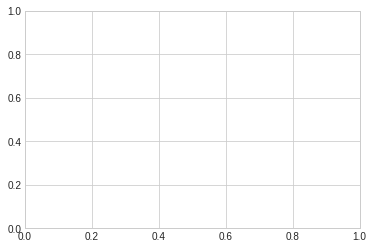

In [65]:
from sklearn.manifold import TSNE   # 저차원으로 매핑 시각화 용

X_comp = TSNE(n_components = 2).fit_transform(bc_X)
plt.scatter(X_comp, bc_y)

linear_svc.fit(X_comp, bc_y)
predict = linear_svc.predict(X_comp)
plt.scatter(X_comp, bc_y, color = 'b')
plt.scatter(X_comp, predict, color = 'r')


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


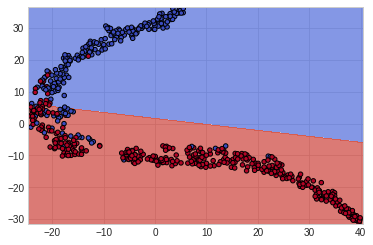

In [67]:

def make_meshgrid(x, y, h = 0.02):
  x_min = x.min() - 0.5
  x_max = x.max() + 0.5
  y_min = y.min() - 0.5
  y_max = y.max() + 0.5

  xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                       np.arange(y_min, y_max, h))
  
  return xx, yy

def plot_contours(cls, xx, yy, **params):
  Z = cls.predict(np.c_[xx.ravel(), yy.ravel()])
  Z = Z.reshape(xx.shape)

  out = plt.contourf(xx, yy, Z, **params)

  return out

model = SVC(kernel = 'linear')
model.fit(X_train, y_train)

X_comp = TSNE(n_components = 2).fit_transform(bc_X)
X0, X1 = X_comp[:, 0], X_comp[:, 1]
xx, yy = make_meshgrid(X0, X1)

model.fit(X_comp, bc_y)

plot_contours(model, xx, yy, cmap = plt.cm.coolwarm, alpha = 0.7)
plt.scatter(X0, X1, c = bc_y, cmap = plt.cm.coolwarm, s = 20, edgecolors = 'k')


# Support Vector Regression (SVR)

In [15]:
# Regression
# 켈리포니아 주택 가격 예측 데이터를 사용
from sklearn.datasets import fetch_california_housing

california = fetch_california_housing()

cali_X = california.data
cali_y = california.target

X_train, X_test, y_train, y_test = train_test_split(cali_X, cali_y, test_size = 0.2)

In [16]:
# pre-processing

standard_scaler = StandardScaler()
X_train = standard_scaler.fit_transform(X_train)          # fit은 train 데이터에 대해서만 하면 됨.
X_test = standard_scaler.transform(X_test)

In [ ]:
from sklearn.svm import SVR
# SVR : support vector regression

linear_svr = SVR(kernel = 'linear')
linear_svr.fit(X_train, y_train)

print("Linear SVR train score : {:.3f}".format(linear_svr.score(X_train, y_train)))
print("Linear SVR test score : {:.3f}".format(linear_svr.score(X_test, y_test)))
print()

polynomial_svr = SVR(kernel = 'poly')
polynomial_svr.fit(X_train, y_train)

print("Polynomial SVR train score : {:.3f}".format(polynomial_svr.score(X_train, y_train)))
print("Polynomial SVR test score : {:.3f}".format(polynomial_svr.score(X_test, y_test)))
print()

rbf_svr = SVR(kernel = 'rbf')
rbf_svr.fit(X_train, y_train)

print("RBF SVR train score : {:.3f}".format(rbf_svr.score(X_train, y_train)))
print("RBF SVR test score : {:.3f}".format(rbf_svr.score(X_test, y_test)))
print()